<a href="https://colab.research.google.com/github/Jensen-Phetchampa/Artificial-Neural-Network/blob/main/Diabetes%20GA-NN%20vs.%20Gradient%20based%20NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generation 0: Best Loss = 0.58765
Generation 10: Best Loss = 0.52953
Generation 20: Best Loss = 0.51139
Generation 30: Best Loss = 0.50463
Generation 40: Best Loss = 0.50291
Generation 50: Best Loss = 0.50132
Generation 60: Best Loss = 0.49977
Generation 70: Best Loss = 0.49827
Generation 80: Best Loss = 0.49769
Generation 90: Best Loss = 0.49711
Generation 100: Best Loss = 0.49666
Generation 110: Best Loss = 0.49617
Generation 120: Best Loss = 0.49561
Generation 130: Best Loss = 0.49465
Generation 140: Best Loss = 0.49416
Generation 150: Best Loss = 0.49372
Generation 160: Best Loss = 0.49326
Generation 170: Best Loss = 0.49261
Generation 180: Best Loss = 0.49193
Generation 190: Best Loss = 0.49152
Generation 200: Best Loss = 0.49038
Generation 210: Best Loss = 0.48988
Generation 220: Best Loss = 0.48939
Generation 230: Best Loss = 0.48904
Generation 240: Best Loss = 0.48833
Generation 250: Best Loss = 0.48785
Generation 260: Best Loss = 0.48739
Generation 270: Best Loss = 0.48679
Gen

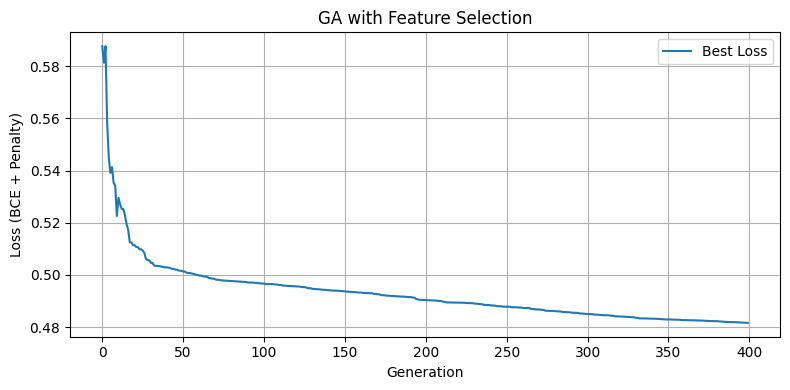


Selected Features: [1, 7]
Total Features Used: 2 / 8

Test Accuracy with Feature Selection: 79.22%
Confusion Matrix:
 [[89 10]
 [22 33]]


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix

# === 1. Load and preprocess the dataset ===
df = pd.read_csv("diabetes.csv")
X = df.drop(columns=["Outcome"]).values
y = df["Outcome"].values.reshape(-1, 1)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 2. Neural network structure ===
input_size = X.shape[1]
hidden_size = 10
output_size = 1  # Single output for binary classification
weight_size = input_size * hidden_size + hidden_size + hidden_size * output_size + output_size
feature_mask_size = input_size
total_genome_size = weight_size + feature_mask_size

# === 3. Neural network forward pass ===
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def forward_pass(X, weights, mask):
    W1, b1, W2, b2 = unpack_weights(weights)
    X_masked = X[:, mask == 1]
    W1_masked = W1[mask == 1]
    hidden = np.tanh(np.dot(X_masked, W1_masked) + b1)
    output = sigmoid(np.dot(hidden, W2) + b2)
    return output

def unpack_weights(weights):
    idx = 0
    W1 = weights[idx:idx + input_size * hidden_size].reshape(input_size, hidden_size)
    idx += input_size * hidden_size
    b1 = weights[idx:idx + hidden_size]
    idx += hidden_size
    W2 = weights[idx:idx + hidden_size * output_size].reshape(hidden_size, output_size)
    idx += hidden_size * output_size
    b2 = weights[idx:idx + output_size]
    return W1, b1, W2, b2

# === 4. Fitness function with feature selection ===
def fitness(genome):
    weights = genome[:weight_size]
    mask = genome[weight_size:].astype(bool)

    if not np.any(mask):  # Avoid empty feature sets
        return -np.inf

    y_pred = forward_pass(X_train, weights, mask)
    y_pred = np.clip(y_pred, 1e-8, 1 - 1e-8)
    loss = -np.mean(y_train * np.log(y_pred) + (1 - y_train) * np.log(1 - y_pred))

    feature_penalty = 0.01 * np.sum(mask)  # Penalize using more features
    return -(loss + feature_penalty)

# === 5. Genetic Algorithm with Feature Selection ===
def genetic_algorithm(pop_size=400, generations=400, mutation_rate=0.01):
    population = np.random.randn(pop_size, weight_size)
    masks = np.random.randint(0, 2, (pop_size, feature_mask_size))
    genome_population = np.hstack((population, masks))

    best_fitness_list = []

    for gen in range(generations):
        scores = np.array([fitness(ind) for ind in genome_population])
        best_fitness_list.append(-np.max(scores))

        top_idx = scores.argsort()[-pop_size // 5:]
        parents = genome_population[top_idx]

        new_population = []
        for _ in range(pop_size):
            p1, p2 = parents[np.random.randint(len(parents))], parents[np.random.randint(len(parents))]
            point = np.random.randint(total_genome_size)
            child = np.concatenate([p1[:point], p2[point:]])

            # Mutate weights
            mutation = np.random.rand(weight_size) < mutation_rate
            child[:weight_size][mutation] += np.random.randn(np.sum(mutation)) * 0.5

            # Mutate feature mask
            feature_mut = np.random.rand(feature_mask_size) < mutation_rate
            child[weight_size:] = np.logical_xor(child[weight_size:], feature_mut).astype(int)

            new_population.append(child)

        genome_population = np.array(new_population)

        if gen % 10 == 0:
            print(f"Generation {gen}: Best Loss = {-np.max(scores):.5f}")

    plt.figure(figsize=(8, 4))
    plt.plot(best_fitness_list, label="Best Loss")
    plt.xlabel("Generation")
    plt.ylabel("Loss (BCE + Penalty)")
    plt.title("GA with Feature Selection")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    best_idx = np.argmax([fitness(ind) for ind in genome_population])
    return genome_population[best_idx]

# === 6. Run and evaluate ===
best_genome = genetic_algorithm()
best_weights = best_genome[:weight_size]
best_mask = best_genome[weight_size:].astype(bool)

print(f"\nSelected Features: {np.where(best_mask)[0].tolist()}")
print(f"Total Features Used: {np.sum(best_mask)} / {input_size}")

y_pred_test = forward_pass(X_test, best_weights, best_mask)
y_pred_labels = (y_pred_test >= 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_labels)
cm = confusion_matrix(y_test, y_pred_labels)

print(f"\nTest Accuracy with Feature Selection: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", cm)


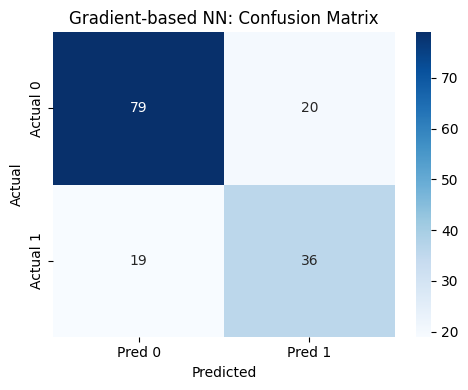


=== Gradient-based NN Results ===
Test Accuracy: 74.68%
Confusion Matrix:
 [[79 20]
 [19 36]]


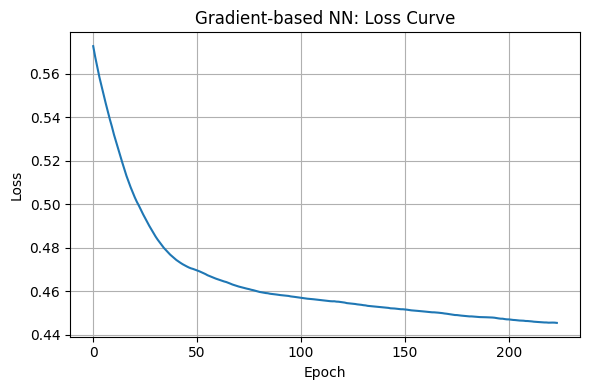


=== Comparison ===
GA-NN Accuracy (with Feature Selection): 79.22%
Gradient-based NN Accuracy:            74.68%


In [6]:
from sklearn.neural_network import MLPClassifier

# === Train gradient-based MLPClassifier on full feature set ===
mlp = MLPClassifier(hidden_layer_sizes=(10,), activation='tanh', max_iter=1000, random_state=42)
mlp.fit(X_train, y_train.ravel())  # .ravel() to convert to 1D

# Predict and evaluate
y_pred_grad = mlp.predict(X_test)

import seaborn as sns
import matplotlib.pyplot as plt

grad_accuracy = accuracy_score(y_test, y_pred_grad)
grad_cm = confusion_matrix(y_test, y_pred_grad)

# === 1. Confusion Matrix Visualization ===
plt.figure(figsize=(5, 4))
sns.heatmap(grad_cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Pred 0", "Pred 1"], yticklabels=["Actual 0", "Actual 1"])
plt.title("Gradient-based NN: Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


print("\n=== Gradient-based NN Results ===")
print(f"Test Accuracy: {grad_accuracy * 100:.2f}%")
print("Confusion Matrix:\n", grad_cm)

# === 2. Loss Curve ===
plt.figure(figsize=(6, 4))
plt.plot(mlp.loss_curve_)
plt.title("Gradient-based NN: Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Compare side by side ===
print("\n=== Comparison ===")
print(f"GA-NN Accuracy (with Feature Selection): {accuracy * 100:.2f}%")
print(f"Gradient-based NN Accuracy:            {grad_accuracy * 100:.2f}%")